<div class="alert alert-block alert-success">
<b>NOTEBOOK 2 - Data Cleaning
</div>

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

The same setup will be used in the all the noteboos so I am not going to include any more comments on that.

In [1]:
# IMPORTS

# Standard libraries
import sys
import importlib
from pathlib import Path
from typing import Union

# Third-party: core scientific
import numpy as np
import pandas as pd

# Add "../src/utilities" to sys.path for custom utilities
sys.path.append("../src/utilities")  # Ensure src/ is in path

# Import utils
try:
    import utils
    importlib.reload(utils)   # Ensures latest version is loaded
except ImportError as e:
    raise ImportError(f"Could not import utils module: {e}")

---
# 2 - DATASET LOAD

### 2.1 - LOADING

Here I have loaded the dataset back in.

In [2]:
# Load dataset
df = utils.load_dataset('../data/interim/students_dropout_data_forCleaning.csv')

Data loaded correctly!


---
# 3 - DATA LEAKAGE PREVENTION

### 3.1 - EARLY POTENTIAL LEAKAGE PREVENTION

To start off, I have used a few code lines to flag any suspiciously future-looking columns. It turned out no columns include any of these words "future|after|label".

In [3]:
### 3.5 - EARLY POTENTIAL LEAKAGE DETECTION

leak_test = df.columns[df.columns.str.contains("future|after|label")]

if len(leak_test) == 0:
    print("No potential leakage columns found.")    
else:
    print("Potential leaks:", leak_test.tolist())

No potential leakage columns found.


### 3.2 - PREDICTION HORIZON

*For this project, the chosen prediction horizon is after the first semester.*  
This means the model will only use features available *up to and including the end of Semester 1*, while excluding all features that become observable in Semester 2 or later.

**Concept**:
Predictions are made at a fixed *prediction time* (t₀), for an outcome that happens by *t₀ + h* (the horizon).  
All input features must be observed **on or before t₀**.  
- Using **future data (after t₀)** → *label leakage* (cheating).  
- Using **overly old data** → *noise*.

**Why this horizon?**

- *Early enough to intervene*  
  By the end of the first semester, students still have the majority of their academic program ahead of them.  
  This provides institutions with a realistic window to intervene through tutoring, mentoring, financial aid, or counseling.

- *Stronger predictive power*  
  Features such as 'grades', 'approved curricular units', and 'number of evaluations in Semester 1' capture students’ real engagement and performance.  
  These are well-established predictors of future dropout and academic success.

- *Balances actionability and accuracy*  
  - *Enrollment-only horizon*: highly proactive, but predictions are weak since no academic performance data is available yet.  
  - *Semester 2 horizon*: more accurate, but interventions may come too late, after many dropouts already occur.  
  - *Semester 1 horizon*: the *compromise point* — it provides meaningful signals while leaving enough time for support strategies.


**Caveats**

- *Not as early as enrollment*  
  Students who drop out within the first semester cannot be captured by this approach.  
  Therefore, the model is designed to prevent *later* dropouts, not immediate ones.

- *Risk of label leakage*  
  It is essential to strictly exclude all Semester 2 features ('grades', 'approved units', 'evaluations', etc.), since they would not be available at the chosen horizon. Using them would artificially inflate model performance and make it unrealistic in practice.  
  Also, it is necessary to remove all of the students who dropped during the 1st semester without any evaluation data, because they were no longer observable at decision time. Including them would introduce data leakage.


**Target vs Features**

- The target ('Target' column) is not decided at Semester 1 – it is decided later, after years of observation (official end of the course).  
- At the time of collection, there are three different label classes:  
  - *'Dropout'* → the student left the program (at or after Semester 1).  
  - *'Enrolled'* → the student was still studying when the dataset snapshot ended.  
  - *'Graduate'* → the student finished the degree.  

*Key point:* The horizon only limits which *features* can be used. The *target* is always defined in the future, and that is what the model is trying to predict.


**Population groups considered**

Since the time horizon is fixed at the end of Semester 1, I will keep:  
- All demographics / socio-economic / administrative info, established at the beginning of the program.  
- All students who dropped out *after completing the first semester*, because they are observable at the prediction point.  
- All students who remained enrolled or graduated, since their status is decided later and must be predicted.  

**I will drop:**  
- Any feature collected after Semester 1 (to avoid peeking into the future).  
- All students who dropped before completing the first semester, since they were not observable at decision time (they had already dropped).


**Conclusion**

The *Semester 1 horizon* provides a justified compromise between *early detection* and *model reliability*.  
It allows institutions to identify at-risk students with meaningful accuracy, while keeping predictions realistic and actionable within the academic cycle.


In [4]:
# DELETE "AT RISK" COLUMNS

# Remove any columns related to 2nd semester
for col in df.columns:
    if '2nd' in col:
        df.drop(columns=[col], inplace=True)

# Remove "Target" values that are impossible to know at the end of semester 1
sem1_activity_cols = []
for col in df.columns:
    if '1st sem' in col:
        sem1_activity_cols.append(col)

# Evidence of semester-1 activity = sum of values across these cols
evidence = df[sem1_activity_cols].fillna(0).sum(axis=1)
print(evidence)


# Exclude "Dropout" cases with zero sem1 evidence (likely dropped before end of 1st sem)
mask_valid = ~((df["Target"] == "Dropout") & (evidence == 0))

df_valid = df[mask_valid].copy()
print(f"Kept {df_valid.shape[0]} of {df.shape[0]} students")

df_valid.head()

0        0.000000
1       32.000000
2        6.000000
3       33.428571
4       32.333333
          ...    
4419    31.600000
4420    30.000000
4421    36.912500
4422    28.800000
4423    31.666667
Length: 4424, dtype: float64
Kept 4347 of 4424 students


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,14.000000,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,8,6,13.428571,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,9,5,12.333333,0,13.9,-0.3,0.79,Graduate
5,2,39,1,9991,0,19,133.1,1,37,37,...,0,5,10,5,11.857143,0,16.2,0.3,-0.92,Graduate


---
# 4 - STRUCTURAL CLEANUP

Here I am performing a **structural cleanup** which handles data without risking any leakage, as it is non-statistical. This allowes me to operate on the whole dataset (including the target) without making any distinction between train and test sets yet.

### 4.1 - COLUMNS FORMATTING AND RENAME

It's good practice to normalize column names and to keep them short and meaningful. This includes:
- lowercasing
- replacing spaces, slashes, tabs, and parentheses with _

In [5]:
# FORMATTING

# Automatic renaming
df_valid.columns = (
    df_valid.columns
    .str.strip()              # remove accidental whitespace
    .str.lower()              # lowercase
    .str.replace(r"[^\w\s]", "", regex=True)  # remove special chars
    .str.replace(r"\s+", "_", regex=True)     # replace spaces with "_"
)

# Manual renaming (if needed)
df_valid = df_valid.rename(columns={
    "marital_status": "marital",
    "application_mode": "app_mode",
    "application_order": "app_order",
    "course": "course",
    "daytimeevening_attendance": "att_mode",
    "previous_qualification": "prev_qual",
    "previous_qualification_grade": "prev_grade",
    "nacionality": "nationality",
    "mothers_qualification": "mother_qual",
    "fathers_qualification": "father_qual",
    "curricular_units_1st_sem_credited": "sem1_credited",
    "curricular_units_1st_sem_enrolled": "sem1_enrolled",
    "curricular_units_1st_sem_evaluations": "sem1_evals",
    "curricular_units_1st_sem_approved": "sem1_approved",
    "curricular_units_1st_sem_grade": "sem1_grade",
    "curricular_units_1st_sem_without_evaluations": "sem1_noevals",
    "unemployment_rate": "unemp_rate",
    "inflation_rate": "inflation",
    "gdp": "gdp"
})

df_valid.head()

,marital,app_mode,app_order,course,att_mode,prev_qual,prev_grade,nationality,mother_qual,father_qual,...,sem1_credited,sem1_enrolled,sem1_evals,sem1_approved,sem1_grade,sem1_noevals,unemp_rate,inflation,gdp,target
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,14.000000,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,8,6,13.428571,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,9,5,12.333333,0,13.9,-0.3,0.79,Graduate
5,2,39,1,9991,0,19,133.1,1,37,37,...,0,5,10,5,11.857143,0,16.2,0.3,-0.92,Graduate


I have devised a function (see cleaning.data_quality_check()) that performed an overall quality check on the dataset. In my case, there are no date/time or free-text features so Ijust needed to check for formatting issues or other inconsistencies. 

### 3.1 - QUALITY CHECK

This function (see cleaning.data_quality_check()) scans each invidual feature and looks for potential issues with them. More specifically, it focuses on `StudyTimeWeekly`, `GPA` and `Absences` and first analyzes their ranges (and clips them if necessary based on domain knowledge and common sense). It also checks for inconsistencies (format, encoding etc...) within the numeric and categorical features. 

In [6]:
# Run quality check
df_cleaned, report = cleaning.data_quality_check(
    df,
    study_time_col="StudyTimeWeekly",
    gpa_col="GPA",
    absences_col="Absences",
    date_like_cols=["Timestamp"],  # [] or None if you have no date cols
    drop_student_id=True,
    drop_grade_class=True,
    study_time_range=(0, 100),
    remove_study_time_out_of_range=False  # keep near-zeros as signal, per your decision
)

# Print Report
cleaning.print_quality_report(report)

# Saving report
utils.save_report_md(report, "data_quality_report.md")

NameError: name 'cleaning' is not defined

### 3.2 - CHECK TYPES

I have then assigned the right types to the available features as follows. 

In [ ]:
# Fixing Types

# Categorical
categorical_cols = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports",
    "Music", "Volunteering"
]

for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].astype("category")

# Numeric
numeric_cols = []
for col in df_cleaned.columns:
    if col not in categorical_cols:
        numeric_cols.append(col)
        
# Print
print("Numeric columns: "+ str(numeric_cols))
print("Categorical columns: "+ str(categorical_cols))

df_cleaned.info()

Numeric columns: ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
Categorical columns: ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   int64   
 1   Gender             2392 non-null   category
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   category
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   category
 9   Sports             2392 non-null   category
 10  Music              2392 non-null   category
 11  Volunteering       2392 non-null   ca

### 3.3 - HARD CLIPPING

While exploring the relationship between **StudyTimeWeekly** and **GPA**, I noticed that some students reported extremely low study times (values close to 0). At first glance, these could appear as potential noise or measurement errors.  

However, based on the context of the dataset, it seems likely that study time is tracked **automatically by the system/app** rather than being self-reported.  
This means that very small values (a few seconds or minutes) may reflect students who only **logged in briefly**, opened the app, and closed it.  

- These students still attempted the test or engaged minimally, so removing them entirely could bias the analysis.  
- Their **low GPA scores** are consistent with the interpretation that minimal study time corresponds to weaker performance.  
- To highlight the potential distinction, I plotted a **threshold at 1 hour** of weekly study time, comparing GPA distributions above vs below this cutoff.  

> **Decision:** I decided **not to hard-clip** these values, since they likely represent real behavior. Instead, they will be retained in the dataset, with the awareness that they correspond to a specific subgroup of students (very low app engagement).

I made use of some functions stored in analysis.py to make my final decision.


2011    0.001057
949     0.004859
87      0.008031
1330    0.008206
619     0.014337
556     0.015790
2262    0.018117
406     0.025689
738     0.046949
1304    0.060417
1230    0.074393
1697    0.087192
1776    0.106484
546     0.106980
2310    0.112626
2003    0.115413
1004    0.135763
2219    0.162164
398     0.167094
693     0.169030
686     0.184018
1504    0.184832
2220    0.185050
54      0.186206
1415    0.190779
1718    0.194007
1076    0.213403
1808    0.227793
1247    0.230520
1787    0.232898
Name: StudyTimeWeekly, dtype: float64


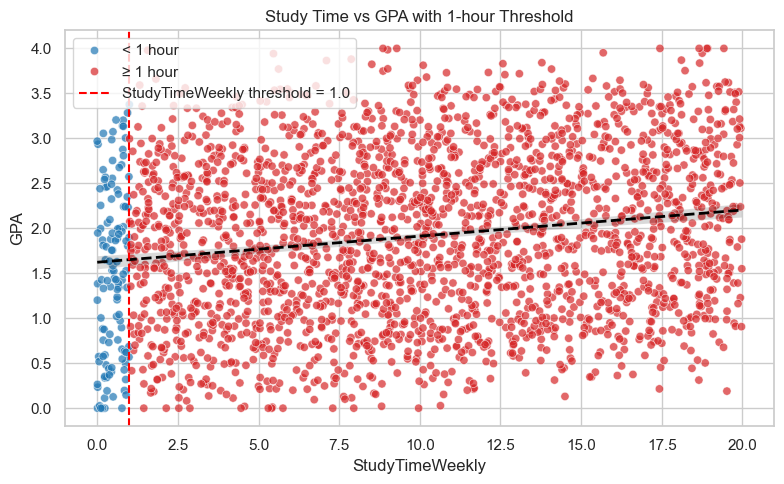

In [ ]:
# Check 30 lowest "StudyTimeWeekly" values
lowest_30 = df_cleaned["StudyTimeWeekly"].nsmallest(30)
print(lowest_30)

# Plot StudyTimeWeekly (with 1 hour threshold) against GPA

analysis.scatter_with_auto_threshold(
    df_cleaned,
    x="StudyTimeWeekly", y="GPA",
    threshold=1.0, axis="x",
    make_groups=True,
    left_label="< 1 hour",
    right_label="≥ 1 hour",
    title="Study Time vs GPA with 1-hour Threshold"
)

During the **structural cleanup phase**, the dataset was examined for a series of common quality issues.  
All of the following checks were performed:

- **Duplicates** → none found.  
- **Obvious errors / impossible values** → none detected.  
- **Encoding errors** → not present.  
- **Wrong units** → no inconsistencies identified.  
- **Format inconsistencies** → none observed across columns.  
- **Future dates / date issues** → not applicable, no datetime fields in this dataset.  
- **Text standardization** → not needed (no free-text fields).  
- **Datetime formatting** → not applicable.  

> These checks confirm that the dataset did not require structural corrections for these categories.  
> Most of these issues were either **handled beforehand** during data collection or are **not applicable** to this dataset (e.g., absence of text/date fields).


In [ ]:
# Save dataset
utils.save_dataset(df_cleaned, 'interim/01_dataset_structural_cleanup.xlsx')

File saved at: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\data\interim\01_dataset_structural_cleanup.xlsx


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   int64   
 1   Gender             2392 non-null   category
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   category
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   category
 9   Sports             2392 non-null   category
 10  Music              2392 non-null   category
 11  Volunteering       2392 non-null   category
 12  GPA                2392 non-null   float64 
dtypes: category(9), float64(2), int64(2)
memory usage: 97.2 KB


<div class="alert alert-block alert-info">
<b>Next Notebook - Data Splitting
</div>